In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import os
from PIL import Image

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import shuffle
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,ConfusionMatrixDisplay
from tensorflow.keras.utils import normalize, to_categorical
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Input,Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense,BatchNormalization

In [3]:
image_directory='chest_dataset/'
normal_images=os.listdir(image_directory+ 'NORMAL/')
pneumonia_images=os.listdir(image_directory+ 'PNEUMONIA/')

print('normal_images: ', len(normal_images))
print('pneumonia_images: ',len(pneumonia_images))

normal_images:  1341
pneumonia_images:  3875


In [4]:
dataset=[]
label=[]

INPUT_SIZE=224

In [5]:
for i , image_name in enumerate(normal_images):
    if(image_name.split('.')[1]=='jpeg'):
        image=cv2.imread(image_directory+'NORMAL/'+image_name)
        image=Image.fromarray(image,'RGB')
        image=image.resize((INPUT_SIZE,INPUT_SIZE))
        dataset.append(np.array(image))
        label.append(0)

In [6]:
for i , image_name in enumerate(pneumonia_images):
    if(image_name.split('.')[1]=='jpeg'):
        image=cv2.imread(image_directory+'PNEUMONIA/'+image_name)
        image=Image.fromarray(image, 'RGB')
        image=image.resize((INPUT_SIZE,INPUT_SIZE))
        dataset.append(np.array(image))
        label.append(1)

In [7]:
dataset = np.array(dataset)
label = np.array(label)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size=0.2, random_state=0)

In [9]:
X_train = X_train/255.0
X_test = X_test/255.0

In [10]:
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Convert target values to one-hot vectors
y_train_encoded = to_categorical(y_train, num_classes=2)
y_test_encoded = to_categorical(y_test, num_classes=2)

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam

# Define the input size
INPUT_SIZE = 224  # You can adjust this to the size required

# Load the pre-trained Xception model and exclude its top layers
base_model = Xception(weights='imagenet', include_top=False, input_shape=(INPUT_SIZE, INPUT_SIZE, 3))

# Freeze the base model layers to prevent them from being trained
base_model.trainable = False

# Create a new Sequential model and add the base model
model = Sequential()
model.add(base_model)

# Add a global average pooling layer to reduce the tensor shape
model.add(GlobalAveragePooling2D())

# Add a fully connected layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Add the output layer with softmax activation for classification
model.add(Dense(2, activation='softmax'))  # Adjust the number of neurons according to your number of classes

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 20992746 (80.08 MB)
Trainable params: 131266 (512.76 KB)
Non-trainable params: 20861480 (79.58 MB)
_________

In [13]:
# Stop training if loss doesn't keep decreasing.
model_es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=10, verbose=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=6, verbose=True)

history_1 = model.fit(X_train, y_train_encoded, batch_size=16, epochs=5, verbose=1, shuffle=False ,
                     validation_data=(X_test, y_test_encoded), callbacks=[model_es, model_rlr])

Epoch 1/5
261/261 [==============================] - 1547s 6s/step - loss: 0.1596 - accuracy: 0.9391 - val_loss: 0.1122 - val_accuracy: 0.9588 - lr: 0.0010
Epoch 2/5
261/261 [==============================] - 1465s 6s/step - loss: 0.1354 - accuracy: 0.9506 - val_loss: 0.1043 - val_accuracy: 0.9674 - lr: 0.0010
Epoch 3/5
261/261 [==============================] - 1355s 5s/step - loss: 0.1238 - accuracy: 0.9540 - val_loss: 0.1016 - val_accuracy: 0.9655 - lr: 0.0010
Epoch 4/5
261/261 [==============================] - 1363s 5s/step - loss: 0.1150 - accuracy: 0.9576 - val_loss: 0.0943 - val_accuracy: 0.9684 - lr: 0.0010
Epoch 5/5
261/261 [==============================] - 1336s 5s/step - loss: 0.1081 - accuracy: 0.9583 - val_loss: 0.0960 - val_accuracy: 0.9713 - lr: 0.0010


In [14]:
# Make predictions softmax
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)  # Get the index of the maximum value

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Val Accuracy = %.2f' % accuracy)

33/33 [==============================] - 212s 6s/step
Val Accuracy = 0.97


In [15]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.model_selection import train_test_split

print("Classification Report:\n",classification_report(y_test,y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.95       270
           1       0.99      0.97      0.98       774

    accuracy                           0.97      1044
   macro avg       0.96      0.97      0.96      1044
weighted avg       0.97      0.97      0.97      1044



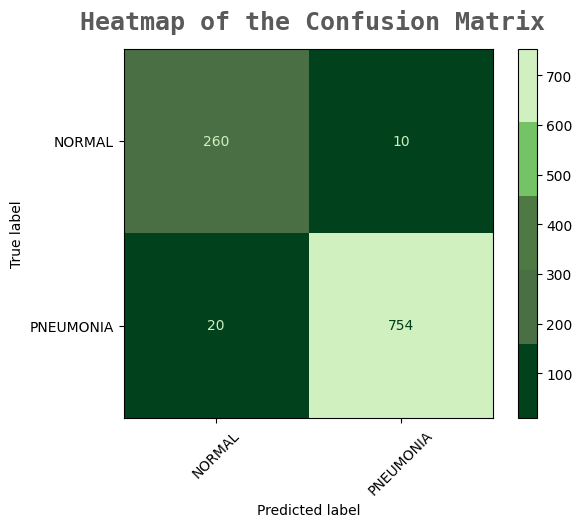

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.colors
import seaborn as sns

labels = ['NORMAL','PNEUMONIA']

colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

# Define the custom color map
custom_colors = ['#01411C', '#4B6F44', '#4F7942', '#74C365', '#D0F0C0']
custom_cmap = matplotlib.colors.ListedColormap(custom_colors)

# Calculate confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)

# Create a display object with the custom color map
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=['NORMAL', 'PNEUMONIA'])

# Plot the confusion matrix
fig, ax = plt.subplots()
disp.plot(cmap=custom_cmap, ax=ax)

# Set the title and axis labels
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.10,alpha=0.8)

# Rotate x-axis labels
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [22]:
def predict(img_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    
    # Define the class labels
    labels = ['NORMAL', 'PNEUMONIA']
    
    plt.figure(figsize=(12, 12))
    plt.style.use('fivethirtyeight')
    
    # Load and preprocess the image
    img = Image.open(img_path)
    resized_img = img.resize((224, 224))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255

    # Make predictions
    predictions = model.predict(img)
    probs = list(predictions[0])
    
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt='%.2f')
    
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


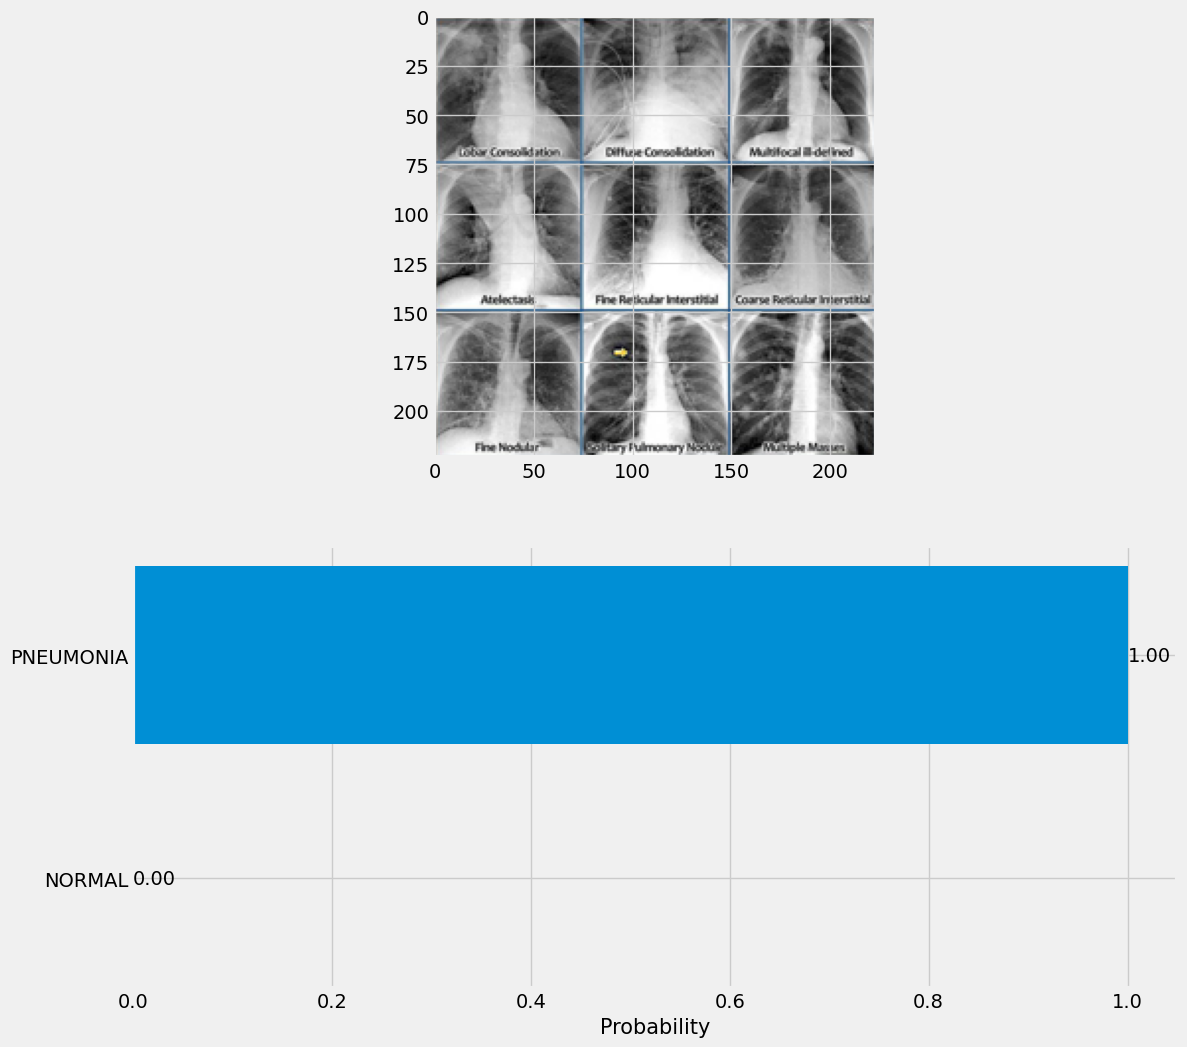

In [24]:
predict("p.jpeg")

In [17]:
model.save("chest_x-ray.h5")

c:\users\admin\myenv1\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
